# Overview
This notebook is intended to provide some easy methods for computing grid convergence.


The governing equation and setup is described below.

## Setup
Let's setup the problem.

Recall, our aim is to solve single-phase flow,
$$-\nabla\cdot K \nabla p = f$$
over the domain $\Omega$. 

The boundary conditions will be defined over $\partial\Omega$, and are mathematically written as
$$p=p_b, \quad -K\nabla p \cdot \mathbf{n} = u_b$$
for Dirichlet ($\partial\Omega_d$) and Neumann ($\partial\Omega_n$) conditions respectively.

$f$ is a scalar source/sink term. $K$ is the permeability matrix. $p_b$ is the pressure at the boundary (Dirichlet), $u_b$ is the flux at the boundary (Neumann).

The basic setup is:
$$
\Omega = [0,1]^2, \quad 
\partial \Omega_n = \{\text{'west', 'east'}\},\quad 
\partial \Omega_d = \{\text{'south', 'north'}\} 
$$

with data: 
$$
f=0, \quad
K=1, \quad 
u_b = 0, \quad
\text{ and }\quad  
p_b = 1 \text{ at top}, \quad
p_b = 0 \text{ at bottom}
$$

In [1]:
# Imports
import numpy as np
import scipy.sparse as sps
import porepy as pp
import matplotlib.pyplot as plt

In [3]:
def sp_flow(g):
    """ Method to compute single phase flow for a given grid."""
    
    # Boundary conditions
    b_faces = g.tags['domain_boundary_faces'].nonzero()[0]
    labels = np.array(['neu']*b_faces.size)
    labels[g.face_centers[1, b_faces] == 0.] = 'dir'
    labels[g.face_centers[1, b_faces] == 1.] = 'dir'
    
    bc = pp.BoundaryCondition(g, b_faces, labels)
    
    # In-flow on top. outflow on bottom.
    #bottom = b_faces[g.face_centers[1, b_faces] == 0.]
    top = b_faces[g.face_centers[1, b_faces] == 1.]
    bc_val = np.zeros(g.num_faces)
    #bc_val[bottom] = np.zeros(bottom.size)
    bc_val[top] = np.ones(top.size)
    
    # Permeability
    perm = pp.SecondOrderTensor(np.ones(g.num_cells))
    
    # Source
    f = np.zeros(g.num_cells)
    
    # Build problem
    specified_parameters = {"second_order_tensor": perm, "source": f, "bc": bc, "bc_values": bc_val}
    data = pp.initialize_default_data(g, {}, "flow", specified_parameters)
    
    # Solve problem
    solver = pp.Tpfa("flow")
    solver.discretize(g, data)
    A, b = solver.assemble_matrix_rhs(g, data)
    p = sps.linalg.spsolve(A, b)
    return p

In [14]:
def grid_convergence(plotting=False):
    """ Compute grid convergence. Use last N as reference value"""
    N = [8,16,32,64,128]
    norm = np.ones(len(N))
    
    #ref_sol = sp_flow()
    for i in range(len(N)):
        Nx = Ny = N[i]
         # Create grid
        g = pp.CartGrid([Nx,Ny], [1,1])
        g.compute_geometry()
        
        # Compute solution
        val = sp_flow(g)
        
        # Compute L2-norm.
        # Not sure if this is accurate since we are not comparing
        # the same volumes, rather doing norm over all current values
        norm[i] = pp.error.norm_L2(g, val)
    
    errors = np.abs(norm[:-1] - norm[-1])
    slope = np.log(errors[-1] / errors[-2]) / np.log(N[-2] / N[-3])
    slope = np.abs(slope)
        
    if plotting:
        plt.loglog(N[:-1], errors)
        plt.title(f"Slope: {slope}")
        plt.show()
    
    return errors, slope
        

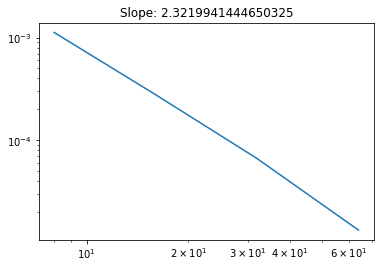

(array([1.12433576e-03, 2.77573320e-04, 6.60767801e-05, 1.32147510e-05]),
 2.3219941444650325)

In [15]:
grid_convergence(True)

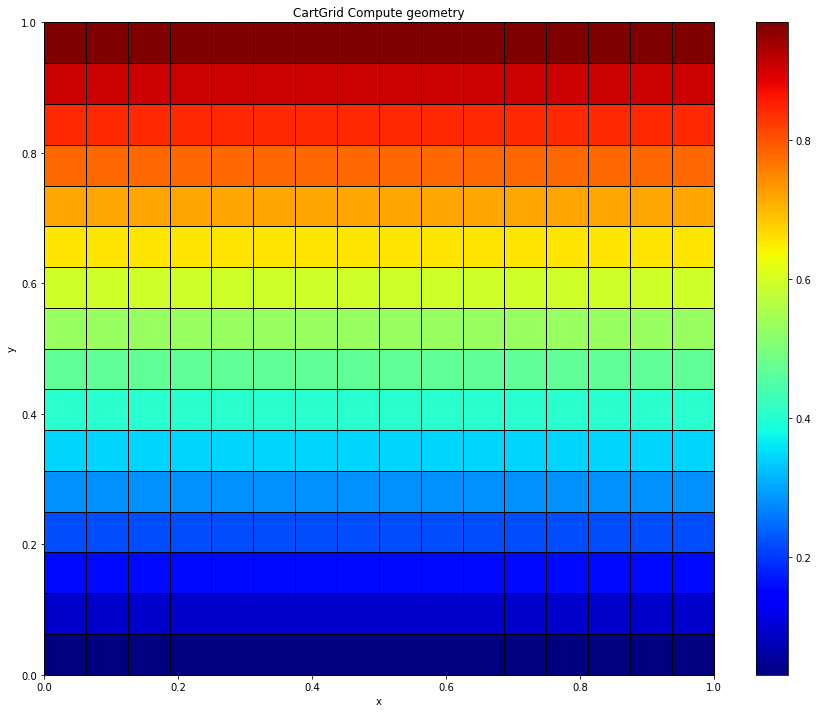

In [7]:
# For reference, a plot of the solution:
Nx = Ny = 16
g = pp.CartGrid([Nx,Ny], [1,1])
g.compute_geometry()
p = sp_flow(g)
pp.plot_grid(g, p, figsize=(15,12), plot_2d=True)